### Main research question
1) Main research question: 
    What are the relationships between specific Alzheimer's disease biomarkers and cognitive decline in the dataset, including positive or negative correlations?
    For statistical purposes we will assume that the null hypothesis is the following; There are no associated positive correlations or negative between the chosen biomarkers and cognitive decline indicators.
### Sub research questions with themes 

##### 1. Data Security  
   - a)  Does the encryption and decryption process using a SHA-256-derived Fernet key ensure secure and reliable access to sensitive Alzheimer’s disease datasets, while maintaining data integrity for subsequent statistical analysis?

##### 2. Dataset Stratification on Core Datasets  
   *(sea-ad_cohort_mtg-tissue_extractions-luminex_data and sea-ad_cohort_donor_metadata_072524)*  
   - a) Are the four Alzheimer’s disease biomarkers sufficiently distinct to enable robust statistical analysis, as evidenced by principal component analysis (PCA) retaining a significant proportion of total variance (e.g., ≥95%) and facilitating k-means clustering to identify separable patient subgroups with potential cognitive decline trajectories?  
   - b) Do biomarker distributions significantly differ between demented and non-demented groups when analyzed using the Mann-Whitney U test, providing a non-parametric validation of the PCA and clustering results?  

##### 3. Correlational Analysis  
   - a) Do individual Alzheimer’s disease biomarkers (ABeta40, ABeta42, tTAU, pTAU) extracted using RIPA and GuHCl buffer methods exhibit statistically significant correlations with cognitive decline?  
   - b) Do these biomarkers also show significant correlations with MMSE test scores?  
   - c) Do volumetric measurements of key brain regions in Alzheimer's (left/right hippocampus, left/right entorhinal cortex) significantly correlate with dementia status, as assessed by point-biserial correlation?  
   - d) Is there a statistically significant association between years of education and the age of dementia diagnosis, as assessed by Spearman correlation in both the base dataset and combined datasets (with kaggle), indicating potential cognitive reserve effects?  
   - e) Does age significantly correlate with dementia diagnosis status, as determined by point-biserial correlation, providing statistical evidence for age as a risk factor in Alzheimer’s disease?  

#### Extra details for improved notebook clarity
For this notebook the sign of a correlation (positive or negative) is meaningful only in the context of the variables analyzed. For example, a Pearson correlation between ABeta42 (pg/ug.1) and a given variable yields r = 0.3693 with p = 0.0005, leading to rejection of the null hypothesis (p < 0.001, strong evidence). Conversely, a Spearman correlation for ABeta42 (pg/ug.1) produces tau = –0.2475 with p = 0.0017, also rejecting the null hypothesis (p < 0.01, strong evidence). These opposing signs are consistent when considering the variables’ scales—specifically, MMSE scores range from 30 (no impairment) to 0 (severe cognitive impairment). 
Additionally different metrics of cognitive decline like MMSE are used to measure the symptom of dementia (which is tightly related to Alzheimers disease as the core symptom) meaning they 
measure the same symptom but in different manners. 

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Step 1 Data Security 

In [24]:
# Reading the encrypted data
import hashlib
import base64
from io import BytesIO
from cryptography.fernet import Fernet

key = "poqwjoifj2398wesd"

def decrypt_file(file_path, key):
    fernet_key = base64.urlsafe_b64encode(hashlib.sha256(key.encode()).digest())
    cipher = Fernet(fernet_key)

    with open(file_path, "rb") as encrypted_file:
        encrypted_data = encrypted_file.read()

    decrypted_data = cipher.decrypt(encrypted_data)
    return decrypted_data

alzheimers_prediction_dataset = pd.read_csv(BytesIO(decrypt_file("./data/alzheimers_prediction_dataset.csv", key)))
sea_ad_cohort_donor_metadata = pd.read_excel(BytesIO(decrypt_file("./data/sea-ad_cohort_donor_metadata_072524 (1).xlsx", key)))
sea_ad_cohort_mri_volumetrics = pd.read_excel(BytesIO(decrypt_file("./data/sea-ad_cohort_mri_volumetrics (2).xlsx", key)))
sea_ad_cohort_mtg_tissue_extractions_luminex_data = pd.read_excel(BytesIO(decrypt_file("./data/sea-ad_cohort_mtg-tissue_extractions-luminex_data (1).xlsx", key)), header=1)

## Step 2 Data evalutation
Evaluating whether the data is suitable for statistical analysis with enough diversity. 
### Substeps:
1. **Understanding data analysis feasiblity via principal component analysis (needed due to biomarker count which makes dimensionality = 8) and k means clustering** 
2. **Understanding whether a signfiicant difference between demented and non demented people exists  in the data (understanding data feasibliy via a second method if 1) fails)**

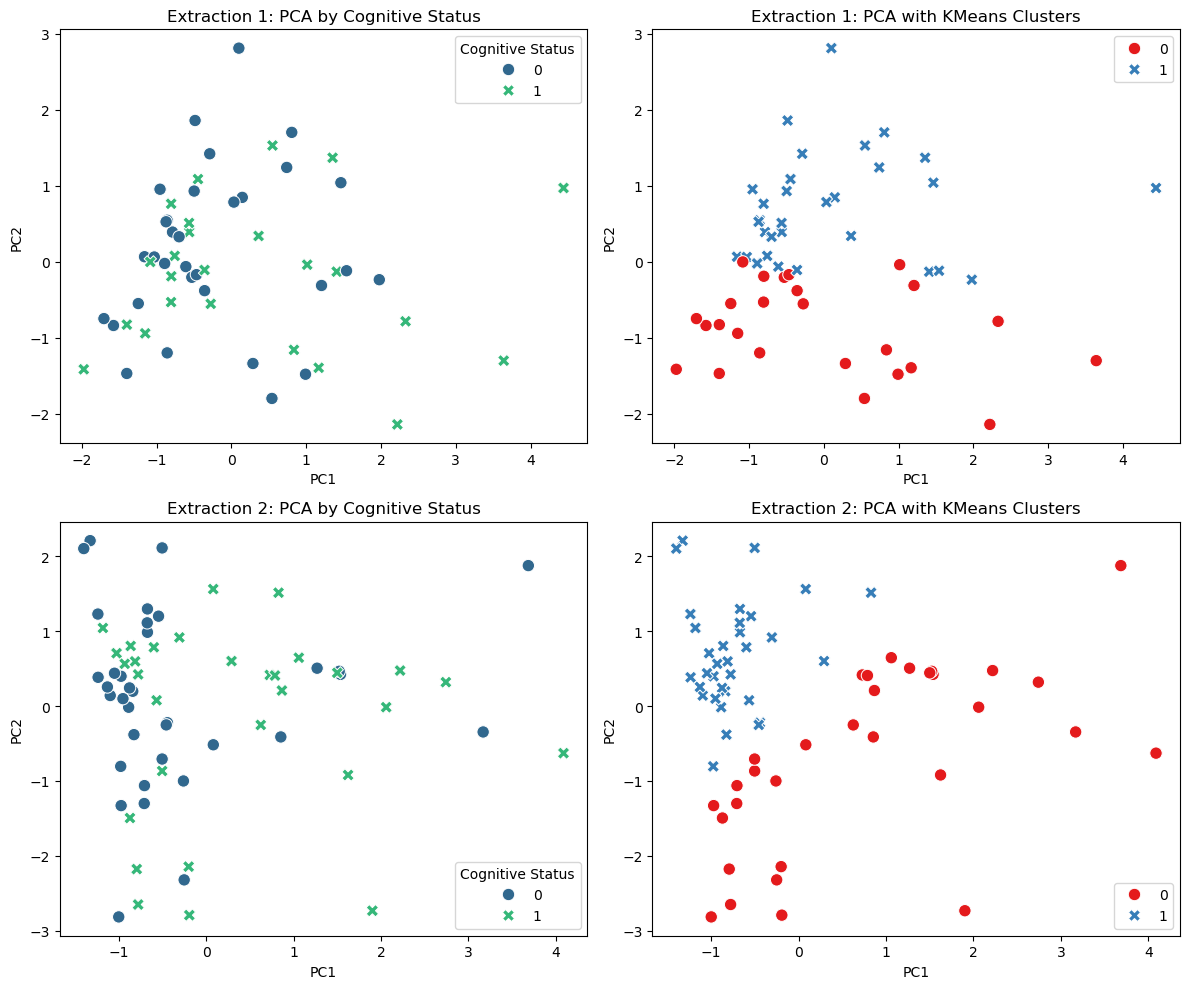

In [34]:
# CODE 1: PCA and k-means clustering using Cognitive Status solely as a visualization label
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

metadata_dementia = sea_ad_cohort_donor_metadata.copy()
markers = sea_ad_cohort_mtg_tissue_extractions_luminex_data.copy()
markers_metadata = markers.merge(metadata_dementia, on="Donor ID", how="inner")


# Define biomarker column sets
biomarker_cols_extr1 = ["ABeta40 pg/ug", "ABeta42 pg/ug", "tTAU pg/ug", "pTAU pg/ug"]
biomarker_cols_extr2 = ["ABeta40 pg/ug.1", "ABeta42 pg/ug.1", "tTAU pg/ug.1", "pTAU pg/ug.1"]

# Extraction 1)
data_clean_extr1 = markers_metadata.dropna(subset=biomarker_cols_extr1)
quantiles_extr1 = {col: data_clean_extr1[col].quantile(0.90) for col in biomarker_cols_extr1}
data_clean_extr1 = data_clean_extr1[(data_clean_extr1[biomarker_cols_extr1] < pd.Series(quantiles_extr1)).all(axis=1)]
scaler_extr1 = StandardScaler()
X_extr1 = scaler_extr1.fit_transform(data_clean_extr1[biomarker_cols_extr1])

# PCA computed only on biomarker features, target (Cognitive Status) is used only in visualization.
pca_extr1 = PCA(n_components=2)
X_pca_extr1 = pca_extr1.fit_transform(X_extr1)
cog_status_extr1 = data_clean_extr1["Cognitive Status"].apply(lambda x: 1 if x == "Dementia" else 0)
kmeans_extr1 = KMeans(n_clusters=2, random_state=42)
clusters_extr1 = kmeans_extr1.fit_predict(X_extr1)

# Extraction 2) 
data_clean_extr2 = markers_metadata.dropna(subset=biomarker_cols_extr2)
quantiles_extr2 = {col: data_clean_extr2[col].quantile(0.95) for col in biomarker_cols_extr2}
data_clean_extr2 = data_clean_extr2[(data_clean_extr2[biomarker_cols_extr2] < pd.Series(quantiles_extr2)).all(axis=1)]
scaler_extr2 = StandardScaler()
X_extr2 = scaler_extr2.fit_transform(data_clean_extr2[biomarker_cols_extr2])
pca_extr2 = PCA(n_components=2)
X_pca_extr2 = pca_extr2.fit_transform(X_extr2)
cog_status_extr2 = data_clean_extr2["Cognitive Status"].apply(lambda x: 1 if x == "Dementia" else 0)
kmeans_extr2 = KMeans(n_clusters=2, random_state=42)
clusters_extr2 = kmeans_extr2.fit_predict(X_extr2)

# Plotting 3) 
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Extraction 1: PCA colored by Cognitive Status (visual) 
sns.scatterplot(x=X_pca_extr1[:, 0], y=X_pca_extr1[:, 1],
                hue=cog_status_extr1, palette="viridis", style=cog_status_extr1, s=80, ax=axs[0, 0])
axs[0, 0].set_title("Extraction 1: PCA by Cognitive Status")
axs[0, 0].set_xlabel("PC1")
axs[0, 0].set_ylabel("PC2")

# Extraction 1: PCA colored by k-means clusters
sns.scatterplot(x=X_pca_extr1[:, 0], y=X_pca_extr1[:, 1],
                hue=clusters_extr1, palette="Set1", style=clusters_extr1, s=80, ax=axs[0, 1])
axs[0, 1].set_title("Extraction 1: PCA with KMeans Clusters")
axs[0, 1].set_xlabel("PC1")
axs[0, 1].set_ylabel("PC2")

# Extraction 2: PCA colored by Cognitive Status
sns.scatterplot(x=X_pca_extr2[:, 0], y=X_pca_extr2[:, 1],
                hue=cog_status_extr2, palette="viridis", style=cog_status_extr2, s=80, ax=axs[1, 0])
axs[1, 0].set_title("Extraction 2: PCA by Cognitive Status")
axs[1, 0].set_xlabel("PC1")
axs[1, 0].set_ylabel("PC2")

# Extraction 2: PCA colored by k-means clusters
sns.scatterplot(x=X_pca_extr2[:, 0], y=X_pca_extr2[:, 1],
                hue=clusters_extr2, palette="Set1", style=clusters_extr2, s=80, ax=axs[1, 1])
axs[1, 1].set_title("Extraction 2: PCA with KMeans Clusters")
axs[1, 1].set_xlabel("PC1")
axs[1, 1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


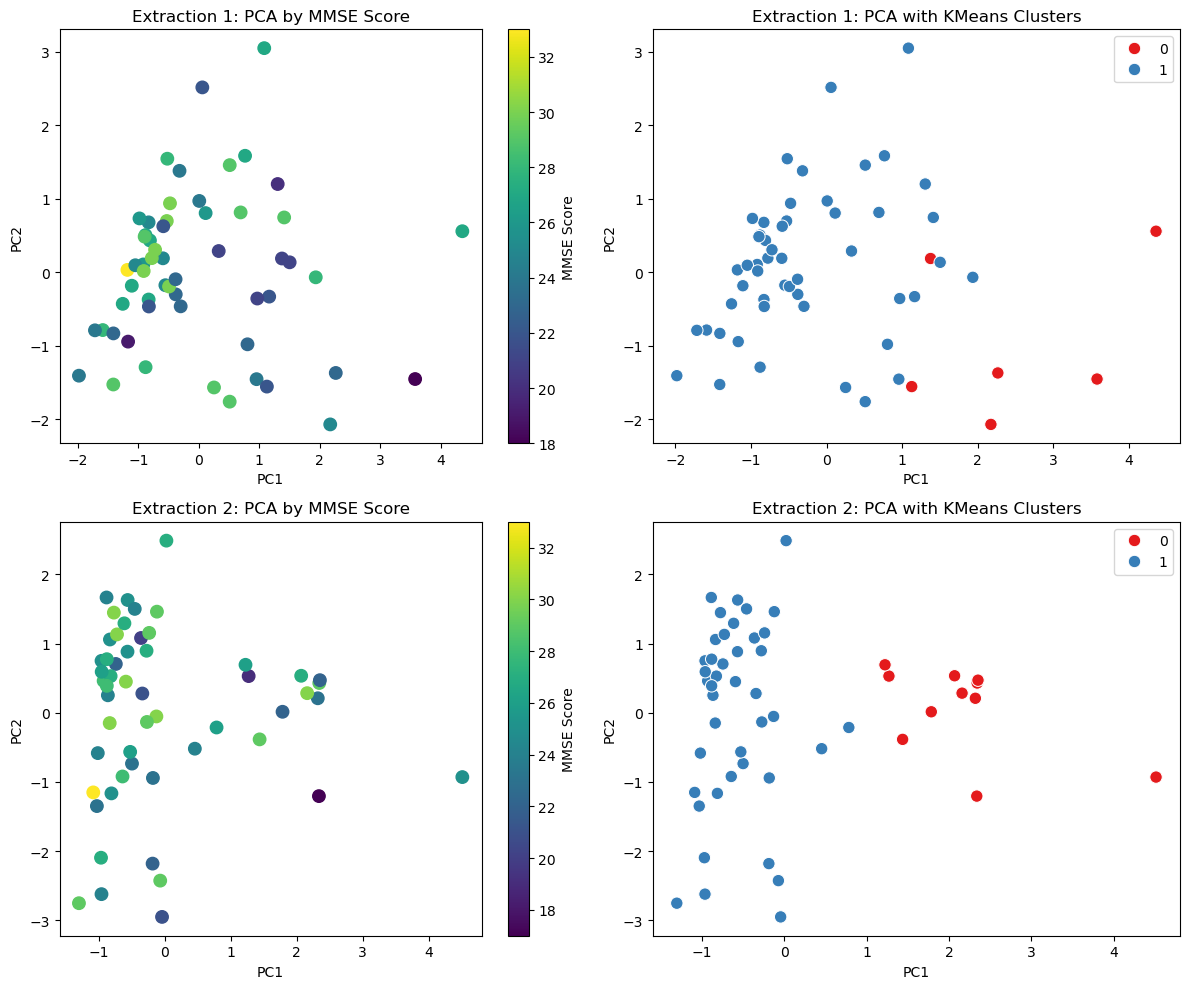

In [ ]:
# CODE 2: PCA and k-means clustering using MMSE Score only for visuals 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# Extraction 1)
# Drop rows missing any biomarker or MMSE value 
data_clean_extr1 = markers_metadata.dropna(subset=biomarker_cols_extr1 + ["Last MMSE Score"])
quantiles_extr1 = {col: data_clean_extr1[col].quantile(0.90) for col in biomarker_cols_extr1}
data_clean_extr1 = data_clean_extr1[(data_clean_extr1[biomarker_cols_extr1] < pd.Series(quantiles_extr1)).all(axis=1)]
scaler_extr1 = StandardScaler()
X_extr1 = scaler_extr1.fit_transform(data_clean_extr1[biomarker_cols_extr1])
# PCA computed only on biomarkers 
pca_extr1 = PCA(n_components=2)
X_pca_extr1 = pca_extr1.fit_transform(X_extr1)
mmse_extr1 = data_clean_extr1["Last MMSE Score"].astype(float)
kmeans_extr1 = KMeans(n_clusters=2, random_state=42)
clusters_extr1 = kmeans_extr1.fit_predict(X_extr1)

# Extraction 2)
data_clean_extr2 = markers_metadata.dropna(subset=biomarker_cols_extr2 + ["Last MMSE Score"])
quantiles_extr2 = {col: data_clean_extr2[col].quantile(0.90) for col in biomarker_cols_extr2}
data_clean_extr2 = data_clean_extr2[(data_clean_extr2[biomarker_cols_extr2] < pd.Series(quantiles_extr2)).all(axis=1)]
scaler_extr2 = StandardScaler()
X_extr2 = scaler_extr2.fit_transform(data_clean_extr2[biomarker_cols_extr2])
pca_extr2 = PCA(n_components=2)
X_pca_extr2 = pca_extr2.fit_transform(X_extr2)
mmse_extr2 = data_clean_extr2["Last MMSE Score"].astype(float)
kmeans_extr2 = KMeans(n_clusters=2, random_state=42)
clusters_extr2 = kmeans_extr2.fit_predict(X_extr2)

# Plotting 3) 
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Extraction 1: PCA colored by MMSE Score
sc1 = axs[0, 0].scatter(X_pca_extr1[:, 0], X_pca_extr1[:, 1],
                        c=mmse_extr1, cmap="viridis", s=80)
axs[0, 0].set_title("Extraction 1: PCA by MMSE Score")
axs[0, 0].set_xlabel("PC1")
axs[0, 0].set_ylabel("PC2")
fig.colorbar(sc1, ax=axs[0, 0], label="MMSE Score")

# Extraction 1: PCA colored by k-means clusters
sns.scatterplot(x=X_pca_extr1[:, 0], y=X_pca_extr1[:, 1],
                hue=clusters_extr1, palette="Set1", s=80, ax=axs[0, 1])
axs[0, 1].set_title("Extraction 1: PCA with KMeans Clusters")
axs[0, 1].set_xlabel("PC1")
axs[0, 1].set_ylabel("PC2")

# Extraction 2: PCA colored by MMSE Score
sc2 = axs[1, 0].scatter(X_pca_extr2[:, 0], X_pca_extr2[:, 1],
                        c=mmse_extr2, cmap="viridis", s=80)
axs[1, 0].set_title("Extraction 2: PCA by MMSE Score")
axs[1, 0].set_xlabel("PC1")
axs[1, 0].set_ylabel("PC2")
fig.colorbar(sc2, ax=axs[1, 0], label="MMSE Score")

# Extraction 2: PCA colored by k-means clusters
sns.scatterplot(x=X_pca_extr2[:, 0], y=X_pca_extr2[:, 1],
                hue=clusters_extr2, palette="Set1", s=80, ax=axs[1, 1])
axs[1, 1].set_title("Extraction 2: PCA with KMeans Clusters")
axs[1, 1].set_xlabel("PC1")
axs[1, 1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


In [ ]:
has_dementia = markers_metadata["Cognitive Status"] == "Dementia"
group_with_dementia = markers_metadata[has_dementia]
group_without_dementia = markers_metadata[~has_dementia]

biomarker_cols_extr1 = ["ABeta40 pg/ug", "ABeta42 pg/ug", "tTAU pg/ug", "pTAU pg/ug"]
biomarker_cols_extr2 = ["ABeta40 pg/ug.1", "ABeta42 pg/ug.1", "tTAU pg/ug.1", "pTAU pg/ug.1"]

# Combine both biomarker lists
biomarkers = biomarker_cols_extr1 + biomarker_cols_extr2

# Significance threshold for P value (alpha)
alpha = 0.05

# Compute Mann–Whitney U test for each biomarker 
results = []
for biomarker in biomarkers:
    # Missing value handling 
    data_with = group_with_dementia[biomarker].dropna()
    data_without = group_without_dementia[biomarker].dropna()
    stat, p_value = stats.mannwhitneyu(data_with, data_without, alternative="two-sided")
    results.append((biomarker, stat, p_value))

# Sort biomarkers by ascending p-value (lowest p indicates strongest evidence of group difference)
results_sorted = sorted(results, key=lambda x: x[2])

# Results in a nice format
print("Biomarker\tU Statistic\tP-value\t\tDecision")
for biomarker, stat, p_value in results_sorted:
    decision = ("Reject null hypothesis: statistically significant difference"
                if p_value < alpha
                else "Fail to reject null hypothesis: insufficient evidence for a difference")
    print(f"{biomarker:20s}\t{stat:10.3f}\t{p_value:10.4f}\t-> {decision}")


Biomarker	U Statistic	P-value		Decision
ABeta40 pg/ug.1     	  1335.000	    0.0001	-> Reject null hypothesis: statistically significant difference
ABeta42 pg/ug.1     	  1321.000	    0.0001	-> Reject null hypothesis: statistically significant difference
ABeta40 pg/ug       	  1270.000	    0.0005	-> Reject null hypothesis: statistically significant difference
ABeta42 pg/ug       	  1223.000	    0.0023	-> Reject null hypothesis: statistically significant difference
tTAU pg/ug.1        	   642.000	    0.0321	-> Reject null hypothesis: statistically significant difference
pTAU pg/ug          	  1009.000	    0.2578	-> Fail to reject null hypothesis: insufficient evidence for a difference
tTAU pg/ug          	   780.000	    0.3639	-> Fail to reject null hypothesis: insufficient evidence for a difference
pTAU pg/ug.1        	   878.500	    0.9786	-> Fail to reject null hypothesis: insufficient evidence for a difference


## Step 3: Correlation Analysis

### Substeps:

1. **Main Group of Correlations 1: Correlating Single Variables with Cognitive Decline**  
   - Example: ABeta40 and cognitive decline, ABeta42 and cognitive decline, etc.  
   - **Variable Groups**:  
     - **RIPA Buffer Extraction**: ABeta40, ABeta42, tTAU, pTAU  
     - **GuHCl (Guanidine Hydrochloride) Buffer Tissue Extraction**: ABeta40, ABeta42, tTAU, pTAU  
   - **Total Correlations**: 8 (each variable correlated with cognitive decline)

2. **Main Group of Correlations 2: Correlating Single Variables with MMSE Test Scores**  
   - Example: ABeta40 and MMSE test scores, ABeta42 and MMSE test scores, etc.  
   - **Variable Groups**:  
     - **RIPA Buffer Extraction**: ABeta40, ABeta42, tTAU, pTAU (each correlated with MMSE test scores)  
     - **GuHCl (Guanidine Hydrochloride) Buffer Tissue Extraction**: ABeta40, ABeta42, tTAU, pTAU (each correlated with MMSE test scores)  
   - **Total Correlations**: 8 (each variable correlated with MMSE test scores)  
  
3. **Main Group of Correlations 3: Correlating Brain Region Volumes with Dementia Diagnosis**  
   - **Regions Analyzed:**  
     - Left Hippocampus Volume  
     - Right Hippocampus Volume  
     - Left Entorhinal Cortex Volume  
     - Right Entorhinal Cortex Volume  
   - **Methodology:**  
     - Extract volumetric data for each brain region.  
     - Merge with cognitive status metadata.  
     - Compute **point-biserial correlation** between each brain region’s volume and dementia diagnosis.  
   - **Significance Threshold:**  
     - p < 0.05 is considered **statistically significant** evidence of association.  
   - **Purpose:**  
     - Identify whether atrophy in specific brain regions is significantly associated with dementia status.  

4. **Main Group of Correlations 4: Correlating Years of Education with Age of Dementia Diagnosis**  
   - **Datasets Used:**  
     - Kaggle dataset (sea-ad_cohort_donor_metadata)  
     - Additional dataset (alzheimers_prediction_dataset)  
   - **Methodology:**  
     - Extract **years of education** and **age at dementia diagnosis** from both datasets.  
     - Compute **Spearman correlation** to assess the relationship between education level and dementia onset age.  
     - Analyze correlations separately for Kaggle and combined datasets.  
   - **Significance Threshold:**  
     - p < 0.05 is considered **statistically significant** evidence of association.  
   - **Purpose:**  
     - Determine whether higher education levels are associated with delayed onset of dementia, providing insights into cognitive reserve effects.  

5. **Main Group of Correlations 5: Correlating Age with Dementia Diagnosis**  
   - **Dataset Used:**  
     - Alzheimer's Prediction Dataset (alzheimers_prediction_dataset)  
   - **Methodology:**  
     - Extract **age** and **dementia diagnosis status**.  
     - Convert dementia diagnosis into a boolean indicator (Yes = True, No = False).  
     - Compute **point-biserial correlation** between age and dementia diagnosis status.  
   - **Significance Threshold:**  
     - p < 0.05 is considered **statistically significant** evidence of association.  
   - **Purpose:**  
     - Assess whether increasing age is significantly associated with dementia diagnosis, reinforcing age as a key risk factor for Alzheimer’s disease.  

In [28]:
### Data preparation and viewing 
### Merging of the datasets with correct patient ID filtering 
metadata_dementia = sea_ad_cohort_donor_metadata.copy()
markers = sea_ad_cohort_mtg_tissue_extractions_luminex_data.copy()
markers_metadata = markers.merge(metadata_dementia, on="Donor ID", how="inner")
markers_metadata.head()

,Donor ID,ABeta40 pg/ug,ABeta42 pg/ug,tTAU pg/ug,pTAU pg/ug,ABeta40 pg/ug.1,ABeta42 pg/ug.1,tTAU pg/ug.1,pTAU pg/ug.1,Primary Study Name,...,CERAD score,Overall CAA Score,Highest Lewy Body Disease,Total Microinfarcts (not observed grossly),Total microinfarcts in screening sections,Atherosclerosis,Arteriolosclerosis,LATE,RIN,Severely Affected Donor
0,H20.33.045,981.444000,142.778000,1122.432229,5.415789,2179.336000,1737.483712,27.065263,2.638947,ADRC Clinical Core,...,Frequent,Not identified,Not Identified (olfactory bulb not assessed),4,4,Moderate,Severe,LATE Stage 2,8.15,NaN
1,H20.33.044,0.007088,0.245263,7005.543158,5.630526,0.203116,0.311579,109.728421,1.957895,ACT,...,Absent,Not identified,Not Identified (olfactory bulb not assessed),3,1,Mild,Moderate,LATE Stage 1,9.20,NaN
2,H21.33.045,21.423158,53.878947,147.565263,11.489474,46.231579,954.656984,14.405263,1.678947,ADRC Clinical Core,...,Frequent,Moderate,Limbic (Transitional),0,0,Moderate,Moderate,LATE Stage 3,6.55,Y
3,H20.33.046,25.295789,69.988421,283.436842,15.917895,46.929474,1103.876312,17.046316,2.871579,ACT,...,Frequent,Moderate,Not Identified (olfactory bulb not assessed),1,1,Moderate,Severe,LATE Stage 2,5.67,Y
4,H20.33.014,0.526168,16.137895,258.624211,3.398947,1.675758,97.642105,83.395789,1.680000,ADRC Clinical Core,...,Sparse,Mild,Olfactory bulb only,1,1,NaN,Mild,Not Identified,8.67,NaN


In [29]:
""""
    1) correlating single variables with single outcomes e.g. ABeta40 and cognitive decline , ABeta42 with cognitive decline and so on and so forth.
    (full list 1: ABeta40, ABeta42, tTAU ,pTAU in RIPA buffer extraction individually with cognitive decline ) 
    (full list 2: ABeta40, ABeta42, tTAU, pTAU in GuHCl (Guanidine Hydrochloride) Buffer Tissue extractions individually with cognitive decline) 
    (total of 8 correlations)
    Type of correlations: a point biserial correlation coefficient and the associated p-value (for hypothesis validation) due to nominal and continuous variables involved.
    The function we are using is two tailed meaning it can infer both negative and positive correaltion outputting the r coefficient, thus our main null hypothesis also has that feature
"""

# Define MMSE scores and prepare correlation tests
has_dementia = markers_metadata["Cognitive Status"] == "Dementia"
stat_tests = []

#Correlate for each mentioned variable
stat_tests.append(("ABeta40 pg/ug", stats.pointbiserialr(has_dementia, markers_metadata["ABeta40 pg/ug"])))
stat_tests.append(("ABeta40 pg/ug.1", stats.pointbiserialr(has_dementia, markers_metadata["ABeta40 pg/ug.1"]))) #.1 signifies the second buffer extraction method i.e. GuHCl (Guanidine Hydrochloride) Buffer Tissue extractions

stat_tests.append(("ABeta42 pg/ug", stats.pointbiserialr(has_dementia, markers_metadata["ABeta42 pg/ug"])))
stat_tests.append(("ABeta42 pg/ug.1", stats.pointbiserialr(has_dementia, markers_metadata["ABeta42 pg/ug.1"])))

stat_tests.append(("tTAU pg/ug", stats.pointbiserialr(has_dementia, markers_metadata["tTAU pg/ug"])))
stat_tests.append(("tTAU pg/ug.1", stats.pointbiserialr(has_dementia, markers_metadata["tTAU pg/ug.1"])))


stat_tests.append(("pTAU pg/ug", stats.pointbiserialr(has_dementia, markers_metadata["pTAU pg/ug"])))
stat_tests.append(("pTAU pg/ug.1", stats.pointbiserialr(has_dementia, markers_metadata["pTAU pg/ug.1"])))


# Sort tests by p-value in ascending order
stat_tests.sort(key=lambda x: x[1].pvalue)
alpha = 0.05  # significance level for p value

# Printing correlation with added result interpretation
for marker_name, stat_result in stat_tests:
    decision = ("Reject null hypothesis: evidence of a statistically significant correlation"
                if stat_result.pvalue < alpha 
                else "Fail to reject null hypothesis: insufficient evidence to infer a correlation")
    print(f"{marker_name}: r = {stat_result.statistic:.4f}, p = {stat_result.pvalue:.4f} -> {decision}")

ABeta42 pg/ug.1: r = 0.3693, p = 0.0005 -> Reject null hypothesis: evidence of a statistically significant correlation
ABeta40 pg/ug: r = 0.1923, p = 0.0796 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation
ABeta42 pg/ug: r = 0.1893, p = 0.0846 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation
ABeta40 pg/ug.1: r = 0.1861, p = 0.0902 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation
pTAU pg/ug: r = 0.1752, p = 0.1110 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation
tTAU pg/ug.1: r = -0.1653, p = 0.1330 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation
tTAU pg/ug: r = -0.1221, p = 0.2685 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation
pTAU pg/ug.1: r = -0.0660, p = 0.5507 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation


In [30]:
""""
    1) correlating single variables with single outcomes e.g. ABeta40 and MMSE test scores , ABeta42 with MMSE test scores and so on and so forth.
    (full list 1: ABeta40, ABeta42, tTAU ,pTAU in RIPA buffer extraction individually with MMSE test scores  ) 
    (full list 2: ABeta40, ABeta42, tTAU, pTAU in GuHCl (Guanidine Hydrochloride) Buffer Tissue extractions individually with MMSE test scores) 
    (total of 8 correlations)
    Type of correlations: a Kendall’s tau correlation with the TAU statistic and the associated p-value (for hypothesis validation) due to continuous and categorical variables involved.
    We chose this type of correlation due to the nominal and continuous variables involved. 
    The function we are using is two tailed meaning it can infer both negative and positive correaltion outputting the r coefficient, thus our main null hypothesis also has that feature
"""

# Define MMSE scores and prepare correlation tests
MMSE = markers_metadata["Last MMSE Score"]
stat_tests_2 = []

# Applying Kendall's tau correlation for each biomarker versus MMSE (omitting NaNs)
stat_tests_2.append(("ABeta40 pg/ug", stats.kendalltau(MMSE, markers_metadata["ABeta40 pg/ug"], nan_policy="omit")))
stat_tests_2.append(("ABeta40 pg/ug.1", stats.kendalltau(MMSE, markers_metadata["ABeta40 pg/ug.1"], nan_policy="omit")))
stat_tests_2.append(("ABeta42 pg/ug", stats.kendalltau(MMSE, markers_metadata["ABeta42 pg/ug"], nan_policy="omit")))
stat_tests_2.append(("ABeta42 pg/ug.1", stats.kendalltau(MMSE, markers_metadata["ABeta42 pg/ug.1"], nan_policy="omit")))
stat_tests_2.append(("tTAU pg/ug", stats.kendalltau(MMSE, markers_metadata["tTAU pg/ug"], nan_policy="omit")))
stat_tests_2.append(("tTAU pg/ug.1", stats.kendalltau(MMSE, markers_metadata["tTAU pg/ug.1"], nan_policy="omit")))
stat_tests_2.append(("pTAU pg/ug", stats.kendalltau(MMSE, markers_metadata["pTAU pg/ug"], nan_policy="omit")))
stat_tests_2.append(("pTAU pg/ug.1", stats.kendalltau(MMSE, markers_metadata["pTAU pg/ug.1"], nan_policy="omit")))

# Sort tests by p-value in ascending order
stat_tests_2.sort(key=lambda x: x[1].pvalue)
alpha = 0.05  # significance level for p value 

# Print the correlation with added result interpretation
for marker_name, stat_result in stat_tests_2:
    decision = ("Reject null hypothesis: statistically significant correlation"
                if stat_result.pvalue < alpha
                else "Fail to reject null hypothesis: insufficient evidence to infer a correlation")
    print(f"{marker_name}: tau = {stat_result.correlation:.4f}, p = {stat_result.pvalue:.4f} -> {decision}")


ABeta42 pg/ug.1: tau = -0.2475, p = 0.0017 -> Reject null hypothesis: statistically significant correlation
ABeta40 pg/ug.1: tau = -0.2314, p = 0.0033 -> Reject null hypothesis: statistically significant correlation
ABeta40 pg/ug: tau = -0.2068, p = 0.0087 -> Reject null hypothesis: statistically significant correlation
pTAU pg/ug: tau = -0.2057, p = 0.0090 -> Reject null hypothesis: statistically significant correlation
ABeta42 pg/ug: tau = -0.1696, p = 0.0313 -> Reject null hypothesis: statistically significant correlation
tTAU pg/ug.1: tau = 0.1249, p = 0.1127 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation
tTAU pg/ug: tau = 0.1058, p = 0.1789 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation
pTAU pg/ug.1: tau = -0.0763, p = 0.3328 -> Fail to reject null hypothesis: insufficient evidence to infer a correlation


In [ ]:
"""
For each brain region (Left/Right Hippocampus and Left/Right Entorhinal Cortex), the code:
- Creates copies of the original metadata and volumetric datasets.
- Extracts and cleans the region-specific data, merging it with dementia metadata using "Donor ID".
- Generates a boolean indicator where `True` denotes "Dementia".
- Computes a point-biserial correlation between dementia status and volumetric measurements with a two-tailed test (p < 0.05, a widely accepted threshold).
Results include the region's name, data dimensions, correlation coefficient, p-value, and whether the result is statistically significant.
A point-biserial correlation is computed between the binary cognitive status and the continuous volumetric measurement for each region.  
   - Rationale: This test is chosen because it is designed to assess the relationship between a dichotomous variable (dementia status) and a continuous variable (brain volume).  
   - The analysis uses a two-tailed test with a significance threshold of p < 0.05, a standard threshold indicating strong evidence when met.
"""

regions = [
    "Left Hippocampus Volume", 
    "Right Hippocampus Volume", 
    "Left Entorhinal Cortex Volume", 
    "Right Entorhinal Cortex Volume"
]

for region in regions:
    
    # Load and decrypt metadata and volumetric data
    metadata_dementia = sea_ad_cohort_donor_metadata.copy()
    volumetric = sea_ad_cohort_mri_volumetrics.copy()

    # Extract region-specific data and remove rows with missing values
    region_vol = volumetric[["Donor ID", region]].dropna()
    merged_df = region_vol.merge(metadata_dementia, on="Donor ID", how="inner")
    
    # Create boolean indicator: True for "Dementia", False otherwise
    has_dementia = merged_df["Cognitive Status"] == "Dementia"
    
    # Calculate point-biserial correlation; evidence: significance threshold set at p < 0.05 (strong evidence if true)
    correlation = stats.pointbiserialr(has_dementia, merged_df[region])
    significance = "significant" if correlation.pvalue < 0.05 else "not significant"
    
    # Display results with detailed statistical values
    print(f"Region: {region}")
    print(f"Data shape (rows, columns): {merged_df.shape}")
    print(f"Point-biserial correlation: r = {correlation.correlation:.3f}, p = {correlation.pvalue:.3f} ({significance})")
    print("-" * 40)

Region: Left Hippocampus Volume
Data shape (rows, columns): (33, 67)
Point-biserial correlation: r = -0.076, p = 0.675 (not significant)
----------------------------------------
Region: Right Hippocampus Volume
Data shape (rows, columns): (46, 67)
Point-biserial correlation: r = -0.466, p = 0.001 (significant)
----------------------------------------
Region: Left Entorhinal Cortex Volume
Data shape (rows, columns): (33, 67)
Point-biserial correlation: r = -0.389, p = 0.025 (significant)
----------------------------------------
Region: Right Entorhinal Cortex Volume
Data shape (rows, columns): (46, 67)
Point-biserial correlation: r = -0.222, p = 0.138 (not significant)
----------------------------------------


In [ ]:
"""
Processing Kaggle Data:
- Extracts "Years of education" and "Age of Dementia diagnosis" after copying metadata.  
- Uses Spearman's correlation since it handles monotonic relationships without assuming normality.  

Processing Additional Data & Combining Datasets:
- Loads and filters additional data for Alzheimer’s diagnosis.  
- Merges datasets and applies Spearman’s correlation again for consistency and robustness to non-linearity.
"""

# Load and preprocess metadata from the Kaggle data source
metadata_dementia = sea_ad_cohort_donor_metadata.copy()
volumetric = sea_ad_cohort_mri_volumetrics.copy()

edu_age_kaggle = metadata_dementia[["Years of education", "Age of Dementia diagnosis"]].dropna()

# Compute Spearman correlation for Kaggle data
spearman_kaggle = stats.spearmanr(
    edu_age_kaggle["Age of Dementia diagnosis"],
    edu_age_kaggle["Years of education"]
)
significance_kaggle = "significant" if spearman_kaggle.pvalue < 0.05 else "not significant"

print("Kaggle Data:")
print(f"Spearman correlation: r = {spearman_kaggle.correlation:.3f}, "
      f"p = {spearman_kaggle.pvalue:.3f} ({significance_kaggle})")
print("-" * 40)

# Load and preprocess additional data
more_data = pd.read_csv(
    BytesIO(decrypt_file("./data/alzheimers_prediction_dataset.csv", key))
)
more_data = more_data[more_data["Alzheimer’s Diagnosis"] == "Yes"]

edu_age_more = more_data[["Education Level", "Age"]].rename(columns={
    "Education Level": "Years of education",
    "Age": "Age of Dementia diagnosis"
})

# Combine datasets
combined_data = pd.concat([edu_age_kaggle, edu_age_more])

# Compute Spearman correlation for combined data
spearman_combined = stats.spearmanr(
    combined_data["Age of Dementia diagnosis"],
    combined_data["Years of education"]
)
significance_combined = "significant" if spearman_combined.pvalue < 0.05 else "not significant"

print("Combined Data:")
print(f"Spearman correlation: r = {spearman_combined.correlation:.3f}, "
      f"p = {spearman_combined.pvalue:.3f} ({significance_combined})")
print("-" * 40)


Kaggle Data:
Spearman correlation: r = -0.128, p = 0.457 (not significant)
----------------------------------------
Combined Data:
Spearman correlation: r = 0.005, p = 0.359 (not significant)
----------------------------------------


In [ ]:
"""
- Loads dataset and filters for Alzheimer’s diagnosis.  
- Creates a boolean indicator for dementia presence.  
- Computes point-biserial correlation between age and dementia status,  
  as it measures the relationship between a binary and continuous variable.  
- Outputs correlation coefficient, p-value, and significance status.
"""
# Load additional data
more_data = pd.read_csv(BytesIO(decrypt_file("./data/alzheimers_prediction_dataset.csv", key)))

# Create boolean indicator for dementia diagnosis
has_dementia = more_data["Alzheimer’s Diagnosis"] == "Yes"

# Compute point-biserial correlation between age and dementia diagnosis
pb_corr = stats.pointbiserialr(has_dementia, more_data["Age"])
significance = "significant" if pb_corr.pvalue < 0.05 else "not significant"

# Output detailed results
print("Age vs. Dementia Diagnosis:")
print(f"Data shape: {more_data.shape}")
print(f"Point-biserial correlation: r = {pb_corr.correlation:.3f}, p = {pb_corr.pvalue:.3f} ({significance})")


Age vs. Dementia Diagnosis:
Data shape: (74283, 25)
Point-biserial correlation: r = 0.420, p = 0.000 (significant)
